# Setup

*   Connecting to drive
*   Configuring GPU
*   Importing and Installing all the required libraries

In [ ]:
from google.colab import drive
drive._mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install simpleITK
!pip install xlsxwriter
!pip install voxelmorph

In [ ]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
from skimage import data
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os, sys
import keras.layers
import nibabel as nib
import matplotlib.pyplot as plt
import re
import SimpleITK as sitk
import os
import xlsxwriter
from scipy.ndimage import zoom

import voxelmorph as vxm
import neurite as ne

import skimage.transform as skTrans
import glob

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
# Tensorflow
import tensorflow as tf
#%tensorflow_version 1.x
#assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'


config = tf.compat.v1.ConfigProto()
#config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#session = tf.compat.v1.Session(config=config)

# Prepare Data [run this only once]

This section load the whole dataset and does the segmentation and saves the data in drive. 

In [ ]:

new_z_dim = 128
reg_type = "bspline"
data_file = "/content/drive/MyDrive/MIRA/FINAL Project/final_code/test_nii_{0}/".format(reg_type)

data = []

list_id = [1, 2, 3, 4, 7, 8, 9, 10, 5, 6, 0]

for val_i in list_id:
  
  name = "copd" + str(val_i)
  print(name)

  inhale_imgPath = data_file + '{0}/{0}_iBHCT.nii.gz'.format(name)
  exhale_imgPath = data_file + '{0}/reg_{0}_eBHCT.nii.gz'.format(name)

  #seg_inhale_imgPath = data_file + '{0}/seg_{0}_iBHCT.nii.gz'.format(name)
  #seg_exhale_imgPath = data_file + '{0}/seg_reg_{0}_eBHCT.nii.gz'.format(name)

  inhale_data = nib.load(inhale_imgPath).get_fdata()
  exhale_data = nib.load(exhale_imgPath).get_fdata()

  #seg_inhale_data = nib.load(seg_inhale_imgPath).get_fdata()
  #seg_exhale_data = nib.load(seg_exhale_imgPath).get_fdata()

  #inhale_data = np.multiply(inhale_data, seg_inhale_data)
  #exhale_data = np.multiply(exhale_data, seg_exhale_data)

  mean = np.mean(inhale_data[np.nonzero(inhale_data)])
  std = np.std(inhale_data[np.nonzero(inhale_data)])
  inhale_data = (inhale_data - mean) / std
  mean = np.mean(exhale_data[np.nonzero(exhale_data)])
  std = np.std(exhale_data[np.nonzero(exhale_data)])
  exhale_data = (exhale_data - mean) / std

  factor = new_z_dim / inhale_data.shape[2]

  if(val_i == 0): # copd0 is already has 256 X 256 in the x and y dimensions
    new_inhale = np.expand_dims(zoom(inhale_data, (1, 1, factor)), axis=0)
    new_exhale = np.expand_dims(zoom(exhale_data, (1, 1, factor)), axis=0)
  else :
    new_inhale = np.expand_dims(zoom(inhale_data, (0.5, 0.5, factor)), axis=0)
    new_exhale = np.expand_dims(zoom(exhale_data, (0.5, 0.5, factor)), axis=0)

  data.append(np.concatenate((new_inhale, new_exhale), axis=0))

#np.save('/content/drive/MyDrive/MIRA/FINAL Project/final_code/saved_data/seg_{0}.npy'.format(reg_type), data)
np.save('/content/drive/MyDrive/MIRA/FINAL Project/final_code/saved_data/normal_{0}.npy'.format(reg_type), data)

copd1
copd2
copd3
copd4
copd7
copd8
copd9
copd10
copd5
copd6
copd0


# Load Preprocessed Data

In this section the saved data is loaded form the drive and training testing split is done.

split_per is the percentage of split of the training. Example: split_per = 90 means train and test data will be split in 9:1 ratio.

In [ ]:
reg_type = "bspline"
data_file = "/content/drive/MyDrive/MIRA/FINAL Project/final_code/test_nii_{0}/".format(reg_type)

# load data numpy file
data = np.load('/content/drive/MyDrive/MIRA/FINAL Project/final_code/saved_data/seg_{0}.npy'.format(reg_type))
#data = np.load('/content/drive/MyDrive/MIRA/FINAL Project/final_code/saved_data/normal_{0}.npy'.format(reg_type))

print(data.shape)

# split intot training and validation
# trained only on first 8 copd instances
split_per = 70
train_split = int((split_per/100) * len(data))
data_train = data[:train_split, ...]
data_val = data[train_split:, ...]

print('train shape:', data_train.shape)

(11, 2, 256, 256, 128)
train shape: (7, 2, 256, 256, 128)


# Prepare the Data Generator

In this section the function for data augmentation is defined and called.

In [ ]:
BATCH_SIZE_ = 1

In [ ]:
def vxm_data_generator(x_data, batch_size):
    """
    generator that takes in data of size [N, X, Y, Z], and yields data for our vxm model

    Note that we need to provide numpy data for each input, and each output

    inputs:  moving_image [bs, x, y, z, 1], fixed_image [bs, x, y, z, 1]
    outputs: moved_image  [bs, x, y, z, 1], zeros [bs, x, y, z, 2]
    """
    # preliminary sizing
    vol_shape = x_data.shape[2:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation.
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs
        # inputs need to be of the size [batch_size, x, y, z, 1]

        idx = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx, 0, ..., np.newaxis]
        moving_images = x_data[idx, 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        outputs = [fixed_images, zero_phi]

        yield inputs, outputs

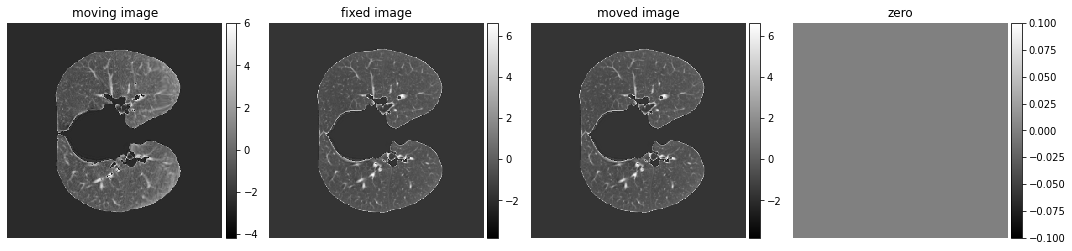

(<Figure size 1080x270 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48fd2d6ad0>,
       dtype=object))

In [ ]:
# create the data generator
train_generator = vxm_data_generator(data_train, BATCH_SIZE_)

# visualize a sample
input_sample, output_sample = next(train_generator)

slices_2d = [f[0, :, :, 60, 0] for f in input_sample + output_sample]
titles = ['moving image', 'fixed image', 'moved image', 'zero']
ne.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True)


# Build the VoxelMorph model

In this section, the entire VoxelMorph architecture is defined along with the loss functions and the optimizer to be used.

In [ ]:
# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model using VxmDense
inshape = data_train.shape[2:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

In [ ]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 256, 256, 128, 1), (None, 256, 256, 128, 1)
output shape: (None, 256, 256, 128, 1), (None, 256, 256, 128, 3)


In [ ]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [ ]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train Model

In this section, the training of VoxelMorph happens. The number of epoch and early stopping are defined here as well.

In [ ]:
import time

# train the model
nb_epochs = 100

# earlyStopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min')
#mcp_save = ModelCheckpoint('/content/drive/MyDrive/MIRA/FINAL Project/final_code/results/seg_{0}_train_{1}_test_{2}_epoch_{3}.hdf5'.format(reg_type, split_per, (100-split_per),nb_epochs), save_best_only=True, monitor='loss', mode='min', verbose=1)
mcp_save = ModelCheckpoint('/content/drive/MyDrive/MIRA/FINAL Project/final_code/results/normal_{0}_train_{1}_test_{2}_epoch_{3}.hdf5'.format(reg_type, split_per, (100-split_per),nb_epochs), save_best_only=True, monitor='loss', mode='min', verbose=1)

reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')
steps_per_epoch = data_train.shape[0]

start_time = time.time()
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=1, callbacks=[mcp_save, reduce_lr_loss]);
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.3074 - transformer_loss: 0.3073 - flow_loss: 0.0019
Epoch 00001: loss improved from inf to 0.30736, saving model to /content/drive/MyDrive/MIRA/FINAL Project/final_code/results/normal_bspline_train_70_test_30_epoch_100.hdf5
7/7 [==============================] - 55s 3s/step - loss: 0.3074 - transformer_loss: 0.3073 - flow_loss: 0.0019 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.2446 - transformer_loss: 0.2435 - flow_loss: 0.0222
Epoch 00002: loss improved from 0.30736 to 0.24457, saving model to /content/drive/MyDrive/MIRA/FINAL Project/final_code/results/normal_bspline_train_70_test_30_epoch_100.hdf5
7/7 [==============================] - 22s 3s/step - loss: 0.2446 - transformer_loss: 0.2435 - flow_loss: 0.0222 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.2196 - transformer_loss: 0.2090 - flow_loss: 0.2133
Epoch 00003: loss improved from 0.244

### Visualize Loss function

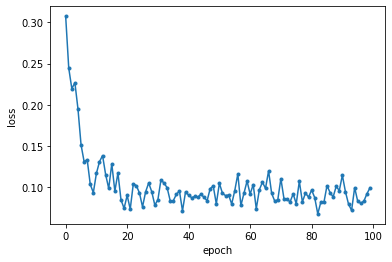

In [ ]:
# as with other imports, this import should be at the top, or use notebook matplotlib magic
# we keep it here to be explicit why we need it
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    # plt.plot(hist.epoch, hist.history['disp_loss'], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Load the Model

In this part of the code the saved model is loaded and the prediciton on the validation data is done and visualized.

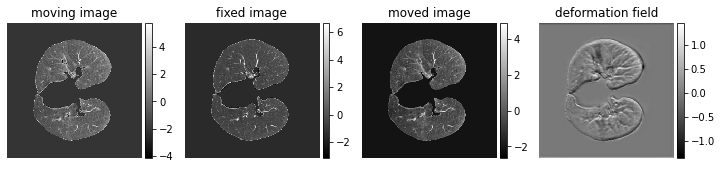

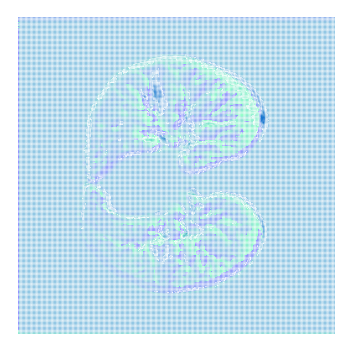

In [ ]:
nb_epochs = 100

# load model
vxm_model.load_weights('/content/drive/MyDrive/MIRA/FINAL Project/final_code/results/seg_{0}_train_90_test_10_epoch_{1}.hdf5'.format(reg_type, nb_epochs))
#vxm_model.load_weights('/content/drive/MyDrive/MIRA/FINAL Project/final_code/results/normal_{0}_train_{1}_test_{2}_epoch_{3}.hdf5'.format(reg_type, split_per, (100-split_per),nb_epochs))

#data generator on val data (copd4)
val_generator = vxm_data_generator(data_val, BATCH_SIZE_)
val_input, _ = next(val_generator)

# predict on validation data (copd4)
val_pred = vxm_model.predict(val_input)

# visualize
slices_2d = [f[0, :, :, 60, 0] for f in val_input + val_pred]
titles = ['moving image', 'fixed image', 'moved image', 'deformation field']
ne.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True, width=10);

# Let's visualize the flow a bit better
ne.plot.flow([val_pred[1][0,:,:,60,0:2].squeeze()], width=5);

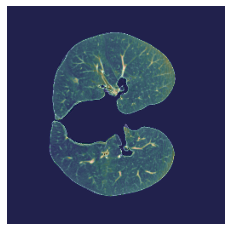

In [ ]:

# overlayying the fixed and the moved(output) image on each other
plt.figure()
plt.axis('off')
plt.imshow(slices_2d[1], 'gray', alpha=1)
plt.imshow(slices_2d[2], 'jet', alpha=0.2)


# Calculate TRE

In this section the TRE is calculated for each COPD data at a time.

*   **calculateTRE** 
  - function to calculate TRE
*   **point_spatial_transformer** 
  - function that transforms the fixed (inhale) landmark points 
*   **before_registration** 
  - function that calculates the TRE between given fixed and moving landmark points
*   **after_registration** 
  - function that gets the prediction of the model and transforms inhale landmark points to calculate the TRE between given fixed and moving landmark points 
  - applicable for copd 1,2,3,4,7,8,9,10 as these are the ones that have the exhale landmark points
*  **save_landmark_points** 
  - function that gets the prediction of the model and transforms inhale landmark points and save them in txt files. 
  - applicable for all copd instances as only does the transformation of inhale points and does not calculate TRE



In [ ]:
def calculateTRE(landmarks_fixed, landmarks_moving, voxel_dimensions):

    # Taking into account the voxel size
    landmarks_moving = voxel_dimensions * landmarks_moving
    landmarks_fixed  = voxel_dimensions * landmarks_fixed

    # Calculated the squared difference (euclidean)
    tre = np.sqrt(np.sum((landmarks_fixed - landmarks_moving) ** 2,axis =1))

    # Calculating the mean and std tre
    mean_tre = np.mean(tre)
    std_tre = np.std(tre)

    return mean_tre, std_tre

In [ ]:
def before_registration(id, param, landmarks_moving, landmarks_fixed, voxel_spacing):

  # Calculating the TRE
  mean_tre , std_tre = calculateTRE(landmarks_fixed, landmarks_moving, voxel_spacing)
  print('COPD{0} & {1:.2f} ({2:.2f}) \\\\ \hline'.format(id, mean_tre , std_tre))


In [ ]:
def point_spatial_transformer(surface_points, trf, single=False):
    
    """
    surface_points is a N x D or a N x (D+1) Tensor
    trf is a *volshape x D Tensor
    """

    surface_pts_D = surface_points.get_shape().as_list()[-1]
    trf_D = trf.get_shape().as_list()[-1]
    assert surface_pts_D in [trf_D, trf_D + 1]

    if surface_pts_D == trf_D + 1:
        li_surface_pts = K.expand_dims(surface_points[..., -1], -1)
        surface_points = surface_points[..., :-1]

    # just need to interpolate.
    # at each location determined by surface point, figure out the trf...
    # Note: if surface_points are on the grid, gather_nd should work as well
    fn = lambda x: ne.utils.interpn(x[0], x[1])
    diff = tf.map_fn(fn, [trf, surface_points], dtype=tf.float32)
    ret = surface_points + diff

    if surface_pts_D == trf_D + 1:
        ret = tf.concat((ret, li_surface_pts), -1)

    return ret

In [ ]:
def after_registration(id, param, landmarks_moving, landmarks_fixed, voxel_spacing):
  
  # based on which COPD data you have selected, the dimensions are assigned
  if id == "1":
    sample_data = data[0:1,...]
    z_dim = 121
    
  elif id == "2":
    sample_data = data[1:2,...]
    z_dim = 102

  elif id == "3":
    sample_data = data[2:3,...]
    z_dim = 126

  elif id == "4":
    sample_data = data[3:4,...]
    z_dim = 126

  elif id == "7":
    sample_data = data[4:5,...]
    z_dim = 112

  elif id == "8":
    sample_data = data[5:6,...]
    z_dim = 115

  elif id == "9":
    sample_data = data[6:7,...]
    z_dim = 116

  elif id == "10": 
    sample_data = data[7:8,...]
    z_dim = 135

  

  # data augmentation done on the data
  val_generator = vxm_data_generator(sample_data, batch_size = 1)
  val_input, _ = next(val_generator)

  val_pred = vxm_model.predict(val_input)

  out_results = val_pred[1].squeeze()
  factor = z_dim / out_results.shape[2]

  new_out = zoom(out_results,(2, 2, factor,1),order=1)
 
  data_tf = tf.convert_to_tensor(new_out, dtype=tf.float32)
  data_tf = K.expand_dims(data_tf, 0)

  # Transforming the fixed (inhale) landmark points and then comparing with the exisiting moving (exhale) landmark points
  landmarksF = tf.convert_to_tensor(landmarks_fixed, dtype=tf.float32)
  landmarksF = K.expand_dims(landmarksF, 0)

  transformed_points = point_spatial_transformer(landmarksF, data_tf)

  def tensor_to_array(array_value):
      return array_value.numpy()

  array = tensor_to_array(transformed_points)
  array = array.squeeze()

  #np.savetxt('/content/drive/MyDrive/MIRA/FINAL Project/final_code/saved_data/t_copd{0}_300_iBH_xyz_r1.txt'.format(id), array) 
  # Calculating the TRE 
  mean_tre , std_tre = calculateTRE(array, landmarks_moving, voxel_spacing)
  print('COPD{0} & {1:.2f} ({2:.2f}) \\\\ \hline'.format(id, mean_tre , std_tre))


In [ ]:
def save_landmark_points(id, param, landmarks_fixed, voxel_spacing):
  
   # based on which COPD data you have selected, the dimensions are assigned
  if id == "1":
    sample_data = data[0:1,...]
    z_dim = 121
    
  elif id == "2":
    sample_data = data[1:2,...]
    z_dim = 102

  elif id == "3":
    sample_data = data[2:3,...]
    z_dim = 126

  elif id == "4":
    sample_data = data[3:4,...]
    z_dim = 126

  elif id == "7":
    sample_data = data[4:5,...]
    z_dim = 112

  elif id == "8":
    sample_data = data[5:6,...]
    z_dim = 115

  elif id == "9":
    sample_data = data[6:7,...]
    z_dim = 116

  elif id == "10": 
    sample_data = data[7:8,...]
    z_dim = 135

  elif id == "5":
    sample_data = data[8:9,...]
    z_dim = 131

  elif id == "6":
    sample_data = data[9:10,...]
    z_dim = 119

  elif id == "0": 
    sample_data = data[10:11,...]
    z_dim = 94
  
  

  # data augmentation done on the data
  val_generator = vxm_data_generator(sample_data, batch_size = 1)
  val_input, _ = next(val_generator)

  val_pred = vxm_model.predict(val_input)

  out_results = val_pred[1].squeeze()
  factor = z_dim / out_results.shape[2]
  if(id == 0): # for copd0 the x_dim and y_dim was already 256
    new_out = zoom(out_results,(1, 1, factor,1),order=1)
  else:
    new_out = zoom(out_results,(2, 2, factor,1),order=1)
  
 
  data_tf = tf.convert_to_tensor(new_out, dtype=tf.float32)
  data_tf = K.expand_dims(data_tf, 0)

  # Transforming the fixed (inhale) landmark points and then comparing with the exisiting moving (exhale) landmark points
  landmarksF = tf.convert_to_tensor(landmarks_fixed, dtype=tf.float32)
  landmarksF = K.expand_dims(landmarksF, 0)

  transformed_points = point_spatial_transformer(landmarksF, data_tf)

  def tensor_to_array(array_value):
      return array_value.numpy()

  array = tensor_to_array(transformed_points)
  array = array.squeeze()

  np.savetxt('/content/drive/MyDrive/MIRA/FINAL Project/final_code/saved_data/t_copd{0}_300_iBH_xyz_r1.txt'.format(id), array) 



In [ ]:
# Set this number to the case you want to evaluate (Available Options - 1,2,3,4,7,8,9,10)
#list_id = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_id = [1, 2, 3, 4, 7, 8, 9, 10]

for val_i in list_id:

  id = str(val_i)
  #print("\nWorking on copd - "+id+" ...")

  # Set this path to the file containing all the images
  path_to_data_dir = data_file

  path_to_data_dir = "{0}/copd{1}/".format(path_to_data_dir,id)
  
  # Setting up the input parameters
  param = {}

  # Input Images
  param['inhale'] = path_to_data_dir + 'copd' + id + '_iBHCT.nii.gz'

  # Landmark Images Inhale and Exhale
  param['landmarks_inhale'] = path_to_data_dir + 'copd' + id + '_reg_transformed_points.txt'
  param['landmarks_exhale'] = path_to_data_dir + 'copd' + id + '_300_eBH_xyz_r1.txt'

  # Loading the inhale and exhale landmarks
  landmarks_moving = np.loadtxt(param['landmarks_exhale'])
  landmarks_fixed = np.loadtxt(param['landmarks_inhale'])

  # Getting the voxel spacing in the image
  voxel_spacing = nib.load(param['inhale']).header.get_zooms()
  #print("voxel spacing: ",voxel_spacing)

  #before_registration(id, param, landmarks_moving, landmarks_fixed, voxel_spacing)
  after_registration(id, param, landmarks_moving, landmarks_fixed, voxel_spacing)
  #save_landmark_points(id, param, landmarks_fixed, voxel_spacing)


COPD1 & 2.41 (1.75) \\ \hline
COPD2 & 2.34 (2.53) \\ \hline
COPD3 & 1.32 (0.97) \\ \hline
COPD4 & 1.79 (1.13) \\ \hline
COPD7 & 1.39 (1.03) \\ \hline
COPD8 & 1.63 (1.68) \\ \hline
COPD9 & 1.43 (1.24) \\ \hline
COPD10 & 1.54 (0.90) \\ \hline
